In [15]:
!labelme

### Limitació de la memòria GPU i introducció de les dades a la pipeline de TF

##### Les pipelines de TensorFlow són com una línia de muntatge per a les dades. Imagina que tens un conjunt de peces de joguina que vols muntar en un cotxe. En lloc de fer-ho tot tu mateix, pots crear una línia de muntatge on cada persona fa una petita part del treball. Una persona posa les rodes, una altra posa el motor, una altra posa la carrosseria i així successivament fins que el cotxe està complet. Les pipelines de TensorFlow fan el mateix amb les dades. Les dades passen per diferents etapes on es transformen i es preparen per a l’ús en models d’aprenentatge automàtic. Això ajuda a fer el procés més ràpid i eficient.

In [2]:
#importació de llibreries necessàries
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#limitació de la memòria GPU (buscar doc!!!)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
#carregar imatges dins de la pipeline
imatges = tf.data.Dataset.list_files('data\\images\\*.png') # l'asterisc fa buscar tots els arxius que són png

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.png'

In [9]:
#funció carregar imatge
def carregar_imatge(imatge): 
    byte_img = tf.io.read_file(imatge)
    img = tf.io.decode_png(byte_img)
    return img

In [30]:
imatges = imatges.map(carregar_imatge)

NameError: name 'imatges' is not defined

In [31]:
imatges.as_numpy_iterator().next()

NameError: name 'imatges' is not defined

In [32]:
type(imatges) #si surt "tensorflow.python.data.ops.map_op._MapDataset", les imatges s'han inclòs correctament

NameError: name 'imatges' is not defined

### Divisió de dades per entrenar i validar

In [4]:
import os

In [34]:
def quantImatgesDividir(dir_carpeta):
    num_elements = len(os.listdir(dir_carpeta))
    n_entrenar = round(num_elements*0.7)
    n_provar = round(num_elements*0.15)
    n_validar = num_elements - (n_entrenar + n_provar)
    print(f"Has de posar {n_entrenar} a la carpeta 'train', {n_provar} a la carpeta 'test' i {n_validar} a la carpeta 'val'")

In [35]:
quantImatgesDividir('T:\REP\deteccio_prova\data\images')

Has de posar 0 a la carpeta 'train', 0 a la carpeta 'test' i 0 a la carpeta 'val'


In [36]:
for carpeta in ['train','test','val']:
    for arxiu in os.listdir(os.path.join('data', carpeta, 'images')): #per cada arxiu en cada carpeta
        nom_arxiu = arxiu.split('.')[0]+'.json' #extreu el nom de l'arxiu
        dir_existent = os.path.join('data','labels', nom_arxiu)#crea possible direcció
        if os.path.exists(dir_existent): #si la possible direcció existeix, desplaça l'arxiu .json corresponent
            nova_dir = os.path.join('data',carpeta,'labels',nom_arxiu)
            os.replace(dir_existent, nova_dir)#canviem

## Augment de les dades amb la llibreria Albumentations
##### Per augmentar les caixes delimitadores amb Albumentations, primer cal importar les llibreries necessàries i definir una canalització d’augmentació. A continuació, es defineixen els paràmetres de les caixes delimitadores i s’aplica l’augmentació a les imatges d’entrada. Finalment, es visualitzen les imatges augmentades i les caixes delimitadores corresponents.
##### Una canalització d’augmentació és una sèrie d’operacions d’augmentació que s’apliquen a les imatges d’entrada per obtenir imatges augmentades. Aquestes operacions poden incloure rotacions, escalatats, desplaçaments i altres transformacions geomètriques que s’apliquen a les imatges d’entrada per crear noves imatges que s’utilitzen per entrenar models de detecció d’objectes.


In [5]:
import albumentations as alb
import cv2

In [38]:
#pipeline, el que modifica les imatges
augmentor = alb.Compose([alb.RandomCrop(width=1024, height=1024),
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', #format de coords que volem (buscar docs)
                                                  label_fields=['class_labels']))

In [39]:
imatge = cv2.imread(os.path.join('data','train', 'images','10.png')) #obrim imatge

In [40]:
with open(os.path.join('data', 'train', 'labels', '10.json'), 'r') as f: #obrim json corresponent
    label = json.load(f)

In [41]:
#extreiem les coordenades
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [42]:
#les dividim per a què quadrin amb el model "albumentations" que hem escollit
coords = list(np.divide(coords, [1024,1024,1024,1024]))
#funciona d'una manera proporcional, és a dir, divideix 

In [43]:
coords

[0.5154622395833333,
 0.5724283854166666,
 0.7498372395833333,
 0.8068033854166666]

In [44]:
#aplicar augmentations
augmented = augmentor(image=imatge, bboxes=[coords], class_labels=['Maduixa'])

In [45]:
augmented['bboxes'][0][2:]

(0.7498372395833333, 0.42757161458333337)

In [46]:
augmented['bboxes']


[(0.5154622395833333,
  0.19319661458333337,
  0.7498372395833333,
  0.42757161458333337)]

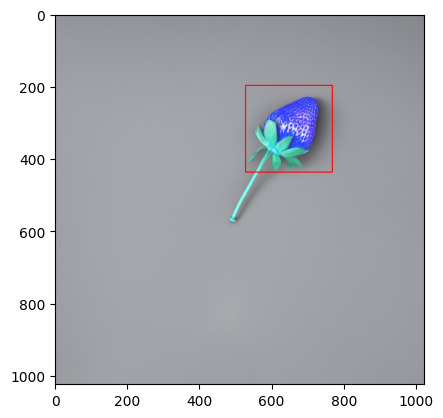

In [47]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [1024,1024]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [1024,1024]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### Pipeline sencera

In [48]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1024,1024,1024,1024]))
            # ^^^ carregar imatges i json ^^^

        try: 
            for x in range(60):# quantitat d'imatges que surten d'una imatge base
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['Maduixa'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])
                
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                    '''
                     La variable “annotation” és un diccionari que conté informació sobre la imatge i 
                     la seva anotació. Si el fitxer d’anotació existeix, el codi afegeix la caixa delimitadora
                     i la classe corresponent a l’objecte detectat a l’estructura “annotation”. 
                     Si el fitxer d’anotació no existeix, el codi assigna una caixa delimitadora i 
                     una classe buida a l’estructura “annotation”.
                    '''
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.6603190104166667, 0.7547200520833334, 0.4471028645833333, 0.5105794270833334, 'Maduixa'].
x_max is less than or equal to x_min for bbox [0.73193359375, 0.30712890625, 0.53173828125, 0.07438151041666664, 'Maduixa'].
x_max is less than or equal to x_min for bbox [0.9793294270833333, 0.8214518229166666, 0.53662109375, 0.38199869791666663, 'Maduixa'].
x_max is less than or equal to x_min for bbox [0.7644856770833333, 0.83935546875, 0.3006184895833333, 0.20458984375, 'Maduixa'].
x_max is less than or equal to x_min for bbox [0.20133463541666669, 0.19156901041666666, 0.012532552083333315, 0.43570963541666663, 'Maduixa'].
x_max is less than or equal to x_min for bbox [0.48779296875000006, 0.80517578125, 0.25830078125, 0.4080403645833333, 'Maduixa'].


### Pujar les labels al TensorFlow  
##### Ara toca crear variables per a tf amb totes les imatges de les carpetes corresponents per a començar l'entrenament de la VGG16

In [10]:
#Obrim les carpetes amb les img a manipular i les carreguem
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg',shuffle=False)
train_images = train_images.map(carregar_imatge)
#Es fa resize de les img i també baixem l'escala de la imatge a 1
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [11]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(carregar_imatge)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [12]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(carregar_imatge)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

In [13]:
'''
Això obté les img i les transforma a un array de NumPy (una estructura de dades en forma de 
taula multidimensional) per al entrenament de la VGG16
'''
train_images.as_numpy_iterator().next() 

array([[[0.41231132, 0.47113487, 0.48289958],
        [0.41050264, 0.4693262 , 0.4810909 ],
        [0.4102723 , 0.46909583, 0.48086053],
        ...,
        [0.46825325, 0.5270768 , 0.5388415 ],
        [0.46310928, 0.5219328 , 0.5336975 ],
        [0.4602197 , 0.51904327, 0.530808  ]],

       [[0.4107572 , 0.46958074, 0.48639643],
        [0.4126638 , 0.4714873 , 0.488303  ],
        [0.4179498 , 0.47677332, 0.493589  ],
        ...,
        [0.46780682, 0.52663034, 0.53839505],
        [0.47234982, 0.53117335, 0.54293805],
        [0.4709648 , 0.5297883 , 0.541553  ]],

       [[0.41418037, 0.47300392, 0.48680785],
        [0.41494682, 0.47377035, 0.48757425],
        [0.4122949 , 0.47111842, 0.48492235],
        ...,
        [0.46854016, 0.52736366, 0.53912836],
        [0.47682944, 0.535653  , 0.5474177 ],
        [0.46556294, 0.52438647, 0.5361512 ]],

       ...,

       [[0.48095685, 0.5397804 , 0.5550902 ],
        [0.48161367, 0.54043716, 0.55220187],
        [0.47375536, 0

### Carregar labels

In [14]:
#funció que carrega els labels
def carregar_labels(x):
    with open(x.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['class']],label['bbox']

In [15]:
'''
incloem els arxius en una Dataset; Un dataset és un conjunt de dades 
que es pot utilitzar per entrenar un model de xarxa neuronal o per 
avaluar-ne el rendiment. TensorFlow Datasets és una col·lecció de 
datasets preparats per utilitzar amb TensorFlow

 L'última línia s’utilitza per aplicar una funció personalitzada a cada element d’un tensor
 de dades TensorFlow. En aquest cas, la funció personalitzada és “carregar_labels”
 i s’aplica a cada element del tensor “train_labels”. La funció “carregar_labels” 
 pren un element x com a entrada i retorna dos tensors de dades TensorFlow com a 
 sortida: un tensor de dades uint8 i un tensor de dades float16. 
 Això significa que la variable “train_labels” conté etiquetes d’imatges
 que s’utilitzen per entrenar un model de xarxa neuronal
 
 Un tensor de dades de TensorFlow és un objecte que representa una matriu
 multidimensional d’elements. Cada element en el tensor té el mateix tipus de dades
 i el tipus de dades és sempre conegut. TensorFlow representa els tensors com a
 matrius n-dimensionals de tipus de dades base. Els tensors són l’estructura de dades 
 principal en TensorFlow i s’utilitzen per representar tant les entrades com les sortides d’un model.
'''
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(carregar_labels, [x], [tf.uint8, tf.float16]))


In [16]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(carregar_labels, [x], [tf.uint8, tf.float16]))

In [17]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(carregar_labels, [x], [tf.uint8, tf.float16]))

In [18]:

''' 
si surt: 
(array([1], dtype=uint8),
 array([n,n,n,n], dtype=float16))
 està bé
'''
train_labels.as_numpy_iterator().next()


(array([1], dtype=uint8),
 array([0.2502, 0.1932, 0.4846, 0.4275], dtype=float16))

### Combinar Labels i imatges

In [19]:
#cal comprovar quantes imatges hi ha en cada carpeta
print("Train: " + str(len(train_labels)) + ", Test: " + str(len(test_labels)) + ", Val: " + str(len(val_labels)))

Train: 1800, Test: 420, Val: 420


In [20]:
train = tf.data.Dataset.zip((train_images, train_labels)) #mètode que junta les imatges amb els labels
train = train.shuffle(2000) #posar el número que hi ha apoximat cap amunt, en aquest cas 2000
train = train.batch(8)#crear lots de 8
train = train.prefetch(4)#redueix la capacitat de procesar per evitar errors crec (buscar)

In [21]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(500)
test = test.batch(8)
test = test.prefetch(4)

In [22]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(500)
val = val.batch(8)
val = val.prefetch(4)

In [23]:
train.as_numpy_iterator().next()[1] #haurien de sortir 8 labels amb si existeix (0 o 1) i les coords

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2537 , 0.1536 , 0.562  , 0.6343 ],
        [0.247  , 0.4797 , 0.561  , 0.7383 ],
        [0.0995 , 0.4175 , 0.4397 , 0.7183 ],
        [0.0796 , 0.175  , 0.5083 , 0.6616 ],
        [0.09644, 0.07886, 0.4978 , 0.5825 ],
        [0.725  , 0.7485 , 0.8564 , 0.921  ],
        [0.4917 , 0.175  , 0.9204 , 0.6616 ],
        [0.2734 , 0.0819 , 0.7573 , 0.68   ]], dtype=float16))

### "Creem" la IA amb l'API function de la VGG16

In [24]:
#La línia 2 importa les capes de Input, de convolució 2D, de connexió i de agregació màxima global
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [25]:
vgg = VGG16(include_top=False) 
#Marca que les ultimes capes de la xarxa no les utilitzarem perque afegirem les nostrtes propies!

In [26]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [27]:
'''
La funció crea i retorna un model de xarxa neuronal convolucional per a la detecció de 
les maduixes. El model té dues parts: una per a determinar si una imatge té una maduixa o no 
i una altra per a localitzar la maduixa en la imatge. 
Al utilitzar VGG16, com que esta pre-entrenada, les característiques del INPUT
i les classifica en dues branques que son les dues parts mencionades abans de manera "automàtica". 
'''

def build_model(): 
    input_layer = Input(shape=(250,250,3))
    
    vgg = VGG16(include_top=False)(input_layer)
    #Model de classificació
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1) #relu == funció que determina la classe; si és maduixa o no
    class2 = Dense(1, activation='sigmoid')(class1) # sigmoid == funció que determina la probabilitat
    '''
    sigmoid = f(x) = 1/(1+e^-x)
    '''
    #Model de localització de coordenades
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [28]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4382, 0.1536, 0.7466, 0.6343],
        [0.1514, 0.332 , 0.452 , 0.6265],
        [0.6577, 0.1185, 0.861 , 0.4207],
        [0.3726, 0.2178, 0.777 , 0.7383],
        [0.2537, 0.3657, 0.562 , 0.846 ],
        [0.67  , 0.4343, 0.881 , 0.703 ],
        [0.2712, 0.1688, 0.672 , 0.538 ],
        [0.3284, 0.1688, 0.7285, 0.538 ]], dtype=float16))

### Prova de la xarxa neuronal :DD

In [29]:
detector = build_model()

In [30]:
'''
Descripció resumida de la xarxa neuronal que acabem de construir,
inclou el nombre de capes, el nombre de paràmetres que ha après durant l'entrenament 
i la forma de les dades que entren i surten de la xarxa.
'''
detector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_3[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [31]:
X, y = train.as_numpy_iterator().next()

In [32]:
X.shape

(8, 250, 250, 3)

In [33]:
classes, coords = detector.predict(X)

1/1 [==============================] - 4s 4s/step


In [34]:
classes, coords

(array([[0.4808506 ],
        [0.41458595],
        [0.49369565],
        [0.4503632 ],
        [0.42670146],
        [0.4932276 ],
        [0.5011447 ],
        [0.4937671 ]], dtype=float32),
 array([[0.49249214, 0.5080006 , 0.19113675, 0.6748703 ],
        [0.51083106, 0.65499765, 0.25369695, 0.6543553 ],
        [0.53460157, 0.53803897, 0.31054655, 0.6241637 ],
        [0.5338668 , 0.59485054, 0.24481687, 0.6621105 ],
        [0.58234626, 0.5397597 , 0.1799118 , 0.7518662 ],
        [0.54039997, 0.54023933, 0.31156492, 0.6268107 ],
        [0.49426454, 0.56628263, 0.18934256, 0.6539333 ],
        [0.48190182, 0.5381017 , 0.29557115, 0.5801181 ]], dtype=float32))

## Definir pèrdues i optimitzadors
##### Els optimitzadors són algorismes que s’utilitzen per ajustar els pesos d’una xarxa neuronal durant l’entrenament. Els optimitzadors són responsables de minimitzar la funció de pèrdua de la xarxa neuronal.

In [35]:
'''
En el context de les xarxes neuronals, un optimitzador és un algorisme
que ajuda a ajustar els paràmetres de la xarxa per aconseguir una millor precisió.
L’optimitzador Adam és un exemple d’això i ajuda a l’optimitzador a convergir més ràpidament
i amb més precisió.
'''
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) #li introduïm el decay que hem calculat a l'optimitzador

In [36]:
'''
La funció té dos components: la pèrdua de localització i la pèrdua de classificació.
La pèrdua de localització mesura la diferència entre les coordenades dels quadres delimitadors 
predits i les coordenades dels quadres delimitadors reals. La pèrdua de classificació mesura la
diferència entre les probabilitats de classe predites i les probabilitats de classe reals. 
En aquesta funció, només es calcula la pèrdua de localització.

La funció té com a entrada dos tensors: y_true i yhat. 
y_true conté les coordenades dels quadres delimitadors reals i
les probabilitats de classe reals per a cada objecte en la imatge d’entrada.
yhat conté les coordenades dels quadres delimitadors predits i les
probabilitats de classe predites per a cada objecte en la imatge d’entrada.

La funció calcula la pèrdua de localització sumant el quadrat de la diferència
entre les coordenades dels quadres delimitadors reals i les coordenades dels quadres
delimitadors predits. A continuació, calcula la diferència entre l’amplada i l’alçada
dels quadres delimitadors reals i els quadres delimitadors predits i suma els quadrats
d’aquestes diferències. Finalment, retorna la suma de les dues pèrdues.
'''

def localization_loss(y_true, yhat):#primer valor: coordenades reals, segon valor: coordenades previstes     
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) #diferència dels dos primers valors de cada fila de la matriu
                  
    h_true = y_true[:,3] - y_true[:,1] #quarta columna d'una matriu - segona columna
    w_true = y_true[:,2] - y_true[:,0] #tercera columna - primera

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    '''
    delta_size = suma dels quadrats de les diferències entre les dimensions originals 
    i les dimensions reconstruïdes de l’imatge.
    '''
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    return delta_coord + delta_size

In [37]:
classloss = tf.keras.losses.BinaryCrossentropy() #model que fa una classificació binaria 
regressloss = localization_loss #model que acabem de crear

In [38]:
#test, en les 2 cel·les inferiors s'hauria d'obtenir : <tf.Tensor: shape=(), dtype=float32, numpy=n>
regressloss(y[1], coords) #y[0] ==> 0 o 1 (hi ha maduixa o no) , y[1] ==> coords (tot del batch sencer)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0858197>

In [39]:
classloss(y[0], classes) #numpy ==> probabilitat

<tf.Tensor: shape=(), dtype=float32, numpy=0.758902>

In [40]:
localization_loss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0858197>

# venga va fes el 10 valenta